# 04 - Modelo con preprocesado alternativo y Random Forest

IMPORTAR LIBRERÍAS

✅ train.csv cargado desde sample_data
Dimensiones: (692500, 21)
✅ Filas con NaN en 'RENDIMIENTO_GLOBAL' eliminadas. Nuevas dimensiones: (692500, 21)
Numéricas: 6
Categóricas: 14
✅ Preprocesamiento alternativo completado.
Tamaño entrenamiento: (554000, 20)
Tamaño validación: (138500, 20)
🔄 Entrenando Random Forest...
✅ Entrenamiento completado.
Accuracy: 0.40707581227436823
              precision    recall  f1-score   support

        alto       0.51      0.60      0.55     35124
        bajo       0.43      0.52      0.47     34597
  medio-alto       0.31      0.23      0.26     34324
  medio-bajo       0.32      0.26      0.29     34455

    accuracy                           0.41    138500
   macro avg       0.39      0.41      0.39    138500
weighted avg       0.39      0.41      0.40    138500



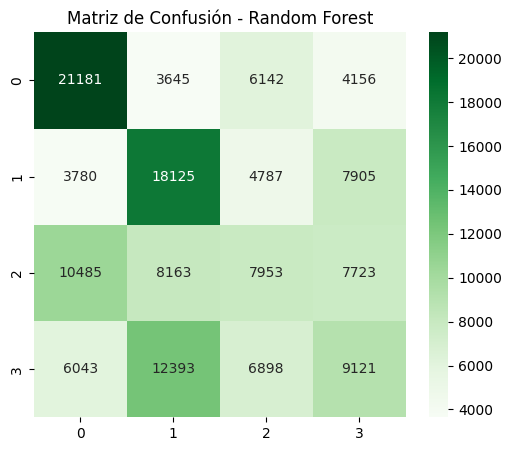

Notebook 04 completado correctamente.


In [2]:
import pandas as pd
import numpy as np
import gc

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.ensemble import RandomForestClassifier

import seaborn as sns
import matplotlib.pyplot as plt

# Para Google Colab
from google.colab import files
import io

# ============================================================
# CARGAR train.csv DESDE LA CARPETA sample_data
# ============================================================

train_path = "/content/sample_data/train.csv"

df = pd.read_csv(train_path, low_memory=False)
print("✅ train.csv cargado desde sample_data")
print("Dimensiones:", df.shape)
df.head()

# ============================================================
# DEFINIR VARIABLE OBJETIVO
# ============================================================

target = "RENDIMIENTO_GLOBAL"

# Eliminar filas con NaN en la variable objetivo antes de dividir X e y
df.dropna(subset=[target], inplace=True)
print(f"✅ Filas con NaN en '{target}' eliminadas. Nuevas dimensiones: {df.shape}")

y = df[target]
X = df.drop(columns=[target])

# ============================================================
# IDENTIFICAR TIPOS DE VARIABLES
# ============================================================

num_cols = X.select_dtypes(include=["int64", "float64"]).columns
cat_cols = X.select_dtypes(include=["object"]).columns

print("Numéricas:", len(num_cols))
print("Categóricas:", len(cat_cols))

# ============================================================
# PREPROCESAMIENTO ALTERNATIVO
# - Imputación simple
# - Label Encoding
# - SIN NORMALIZACIÓN (RF no la requiere)
# ============================================================

# Imputar numéricas
for col in num_cols:
    X[col] = X[col].fillna(X[col].median())

# Imputar categóricas
for col in cat_cols:
    X[col] = X[col].fillna(X[col].mode()[0])

# Label Encoding por columna (mejor para RF)
le_dict = {}  # Guardar transformadores

for col in cat_cols:
    le = LabelEncoder()
    X[col] = le.fit_transform(X[col])
    le_dict[col] = le

print("✅ Preprocesamiento alternativo completado.")

# ============================================================
# REDUCCIÓN DE MEMORIA
# ============================================================

def reduce_memory(df):
    for col in df.columns:
        if df[col].dtype == "int64":
            df[col] = df[col].astype("int32")
        elif df[col].dtype == "float64":
            df[col] = df[col].astype("float32")
    return df

X = reduce_memory(X)

gc.collect()

# ============================================================
# TRAIN / VALIDATION SPLIT
# ============================================================

X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

print("Tamaño entrenamiento:", X_train.shape)
print("Tamaño validación:", X_val.shape)

# ============================================================
# RANDOM FOREST
# ============================================================

rf = RandomForestClassifier(
    n_estimators=250,
    max_depth=25,
    min_samples_split=5,
    min_samples_leaf=2,
    random_state=42,
    n_jobs=-1
)

print("🔄 Entrenando Random Forest...")
rf.fit(X_train, y_train)
print("✅ Entrenamiento completado.")

# ============================================================
# VALIDACIÓN
# ============================================================

y_pred = rf.predict(X_val)

print("Accuracy:", accuracy_score(y_val, y_pred))
print(classification_report(y_val, y_pred))

# MATRIZ DE CONFUSIÓN
plt.figure(figsize=(6,5))
sns.heatmap(confusion_matrix(y_val, y_pred),
            annot=True, fmt="d", cmap="Greens")
plt.title("Matriz de Confusión - Random Forest")
plt.show()

# ============================================================
# LISTO PARA GUARDAR SI FUERA NECESARIO
# ============================================================

print("Notebook 04 completado correctamente.")


Generación de submission.csv

In [3]:
# Cargar test.csv
test_path = "/content/sample_data/test.csv" # Ajusta la ruta si es necesario
df_test = pd.read_csv(test_path, low_memory=False)

# 1. Aplicar Preprocesamiento (Imputación)
# Imputar numéricas (usando la mediana del conjunto de entrenamiento X)
for col in num_cols:
    df_test[col] = df_test[col].fillna(X[col].median()) # Se usa la mediana de X

# Imputar categóricas (usando la moda del conjunto de entrenamiento X)
for col in cat_cols:
    df_test[col] = df_test[col].fillna(X[col].mode()[0]) # Se usa la moda de X

# 2. Aplicar Label Encoding (usando los encoders ajustados en el entrenamiento)
for col in cat_cols:
    # Se utiliza el .transform() del LabelEncoder ajustado previamente
    # NOTA: Puede fallar si hay categorías nuevas en el test que no están en el train.
    # Una solución más robusta sería usar un Pipeline de Sklearn para el preprocesamiento.
    le = le_dict[col]
    df_test[col] = df_test[col].map(lambda s: le.transform([s])[0] if s in le.classes_ else -1) # Manejo simple de clases desconocidas

# 3. Reducir memoria y preparar X_final
df_test = reduce_memory(df_test)
X_final_test = df_test[X_train.columns].copy() # Asegurar que las columnas son las mismas

# 4. Predicción
y_pred_final = rf.predict(X_final_test)

# 5. Mapear de vuelta a las etiquetas originales (si y fue codificada)
# NOTA: Como 'y' nunca fue codificada en el código que pasaste (solo X fue codificado),
# las predicciones ya son strings ('alto', 'bajo', etc.).
submission_df = pd.DataFrame({
    'ID': df_test['ID'],
    target: y_pred_final
})

submission_filename = '04_submission_RF_LE.csv'
submission_df.to_csv(submission_filename, index=False)
print(f"\nArchivo de envío generado: {submission_filename}")


Archivo de envío generado: 04_submission_RF_LE.csv
